# Single cell data

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/jovyan/work/code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from enrichments import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");



Attaching package: ‘ggpp’



    annotate


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [4]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
scores = dme_3d_ds5.clean_scores()
weights = dme_3d_ds5.weights.iloc[:, :3]

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [5]:
scores = dme_3d_ds5.clean_scores().melt(id_vars='label', var_name='G', value_name='G_score')
scores

label   G   G_score
0       V1  G1  2.118031
1       V2  G1  2.048013
2       V3  G1  2.032788
3       V4  G1  1.628794
4        4  G1  1.265557
..     ...  ..       ...
406     A4  G3  1.351602
407  STSva  G3  0.269907
408   TE1m  G3  0.818014
409     PI  G3 -0.052368
410  a32pr  G3 -1.417684

[411 rows x 3 columns]

## PCA on all single cell data??

In [125]:
genes_to_match = set(weights.index)
all_columns = pd.read_csv("../data/allen_single_cell_matrix.csv", nrows=1).columns
matching_column_indices = [i for i, e in enumerate(all_columns) if e in genes_to_match]

weights_matched = weights.loc[list(set(all_columns).intersection(genes_to_match)),:]

In [25]:
metadata.loc[:10000-1,'cell_type']=='Neuro-Ex'

0       False
1       False
2       False
3       False
4       False
        ...  
9995     True
9996     True
9997    False
9998    False
9999    False
Name: cell_type, Length: 10000, dtype: bool

In [26]:
from sklearn.decomposition import PCA
pca_singlecell = (
    pd.read_csv("../data/allen_single_cell_matrix.csv", header=0, usecols=matching_column_indices, nrows=10000)
    .loc[metadata.loc[:10000-1,'cell_type']=='Neuro-Ex', :]
    .add(1)
    .pipe(np.log10)
    .pipe(lambda x: x/x.mean(axis=1).values[:,None])
    .pipe(lambda x: PCA(n_components=5).fit(x))
)

In [27]:
(pd.DataFrame(pca_singlecell.components_.T, index=weights_matched.index)
 .join(weights_matched.set_axis(['G1','G2','G3'],axis=1)).corr()
)

0             1             2             3             4  \
0   1.000000e+00 -3.863234e-16  1.233227e-16 -1.004249e-17  8.598853e-18   
1  -3.863234e-16  1.000000e+00  7.517225e-17 -2.559221e-17 -6.050166e-17   
2   1.233227e-16  7.517225e-17  1.000000e+00 -1.061893e-16 -7.199870e-18   
3  -1.004249e-17 -2.559221e-17 -1.061893e-16  1.000000e+00  1.529559e-16   
4   8.598853e-18 -6.050166e-17 -7.199870e-18  1.529559e-16  1.000000e+00   
G1  7.022726e-03  5.536624e-03 -2.289538e-03 -3.947220e-03  8.487915e-03   
G2  8.081904e-03 -7.491880e-03  4.492356e-03  7.321173e-03 -1.186294e-02   
G3  1.209511e-02  1.559761e-02 -4.930908e-03  5.982165e-04 -5.027581e-03   

          G1        G2        G3  
0   0.007023  0.008082  0.012095  
1   0.005537 -0.007492  0.015598  
2  -0.002290  0.004492 -0.004931  
3  -0.003947  0.007321  0.000598  
4   0.008488 -0.011863 -0.005028  
G1  1.000000 -0.038944 -0.015947  
G2 -0.038944  1.000000 -0.105859  
G3 -0.015947 -0.105859  1.000000

## Cross-plots

In [24]:
sc_axes_posneg_plot = format_single_cell_data_for_plot()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


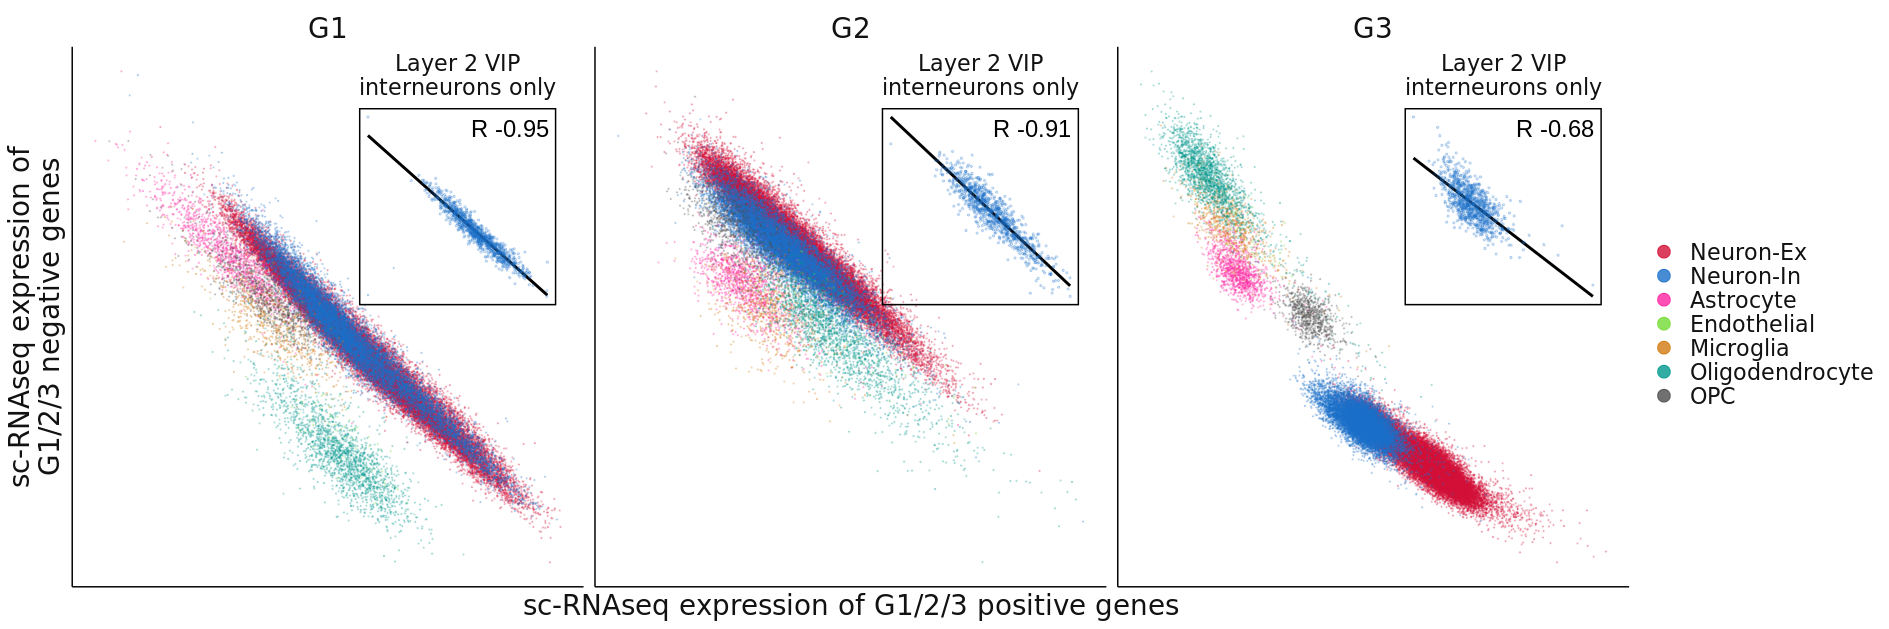

In [21]:
%%R -i sc_axes_posneg_plot -w 48 -h 16 -u cm -r 100
source("../code/Rplots.R")
plot_single_cell_posneg(sc_axes_posneg_plot)

In [28]:
sc_axes_cross_plot = (sc_axes_posneg_plot
 .drop('negative',axis=1).rename({'G':'G_positive'},axis=1)
 .join(sc_axes_posneg_plot.rename({'G':'G_negative'},axis=1).loc[:,['G_negative','negative']])
)

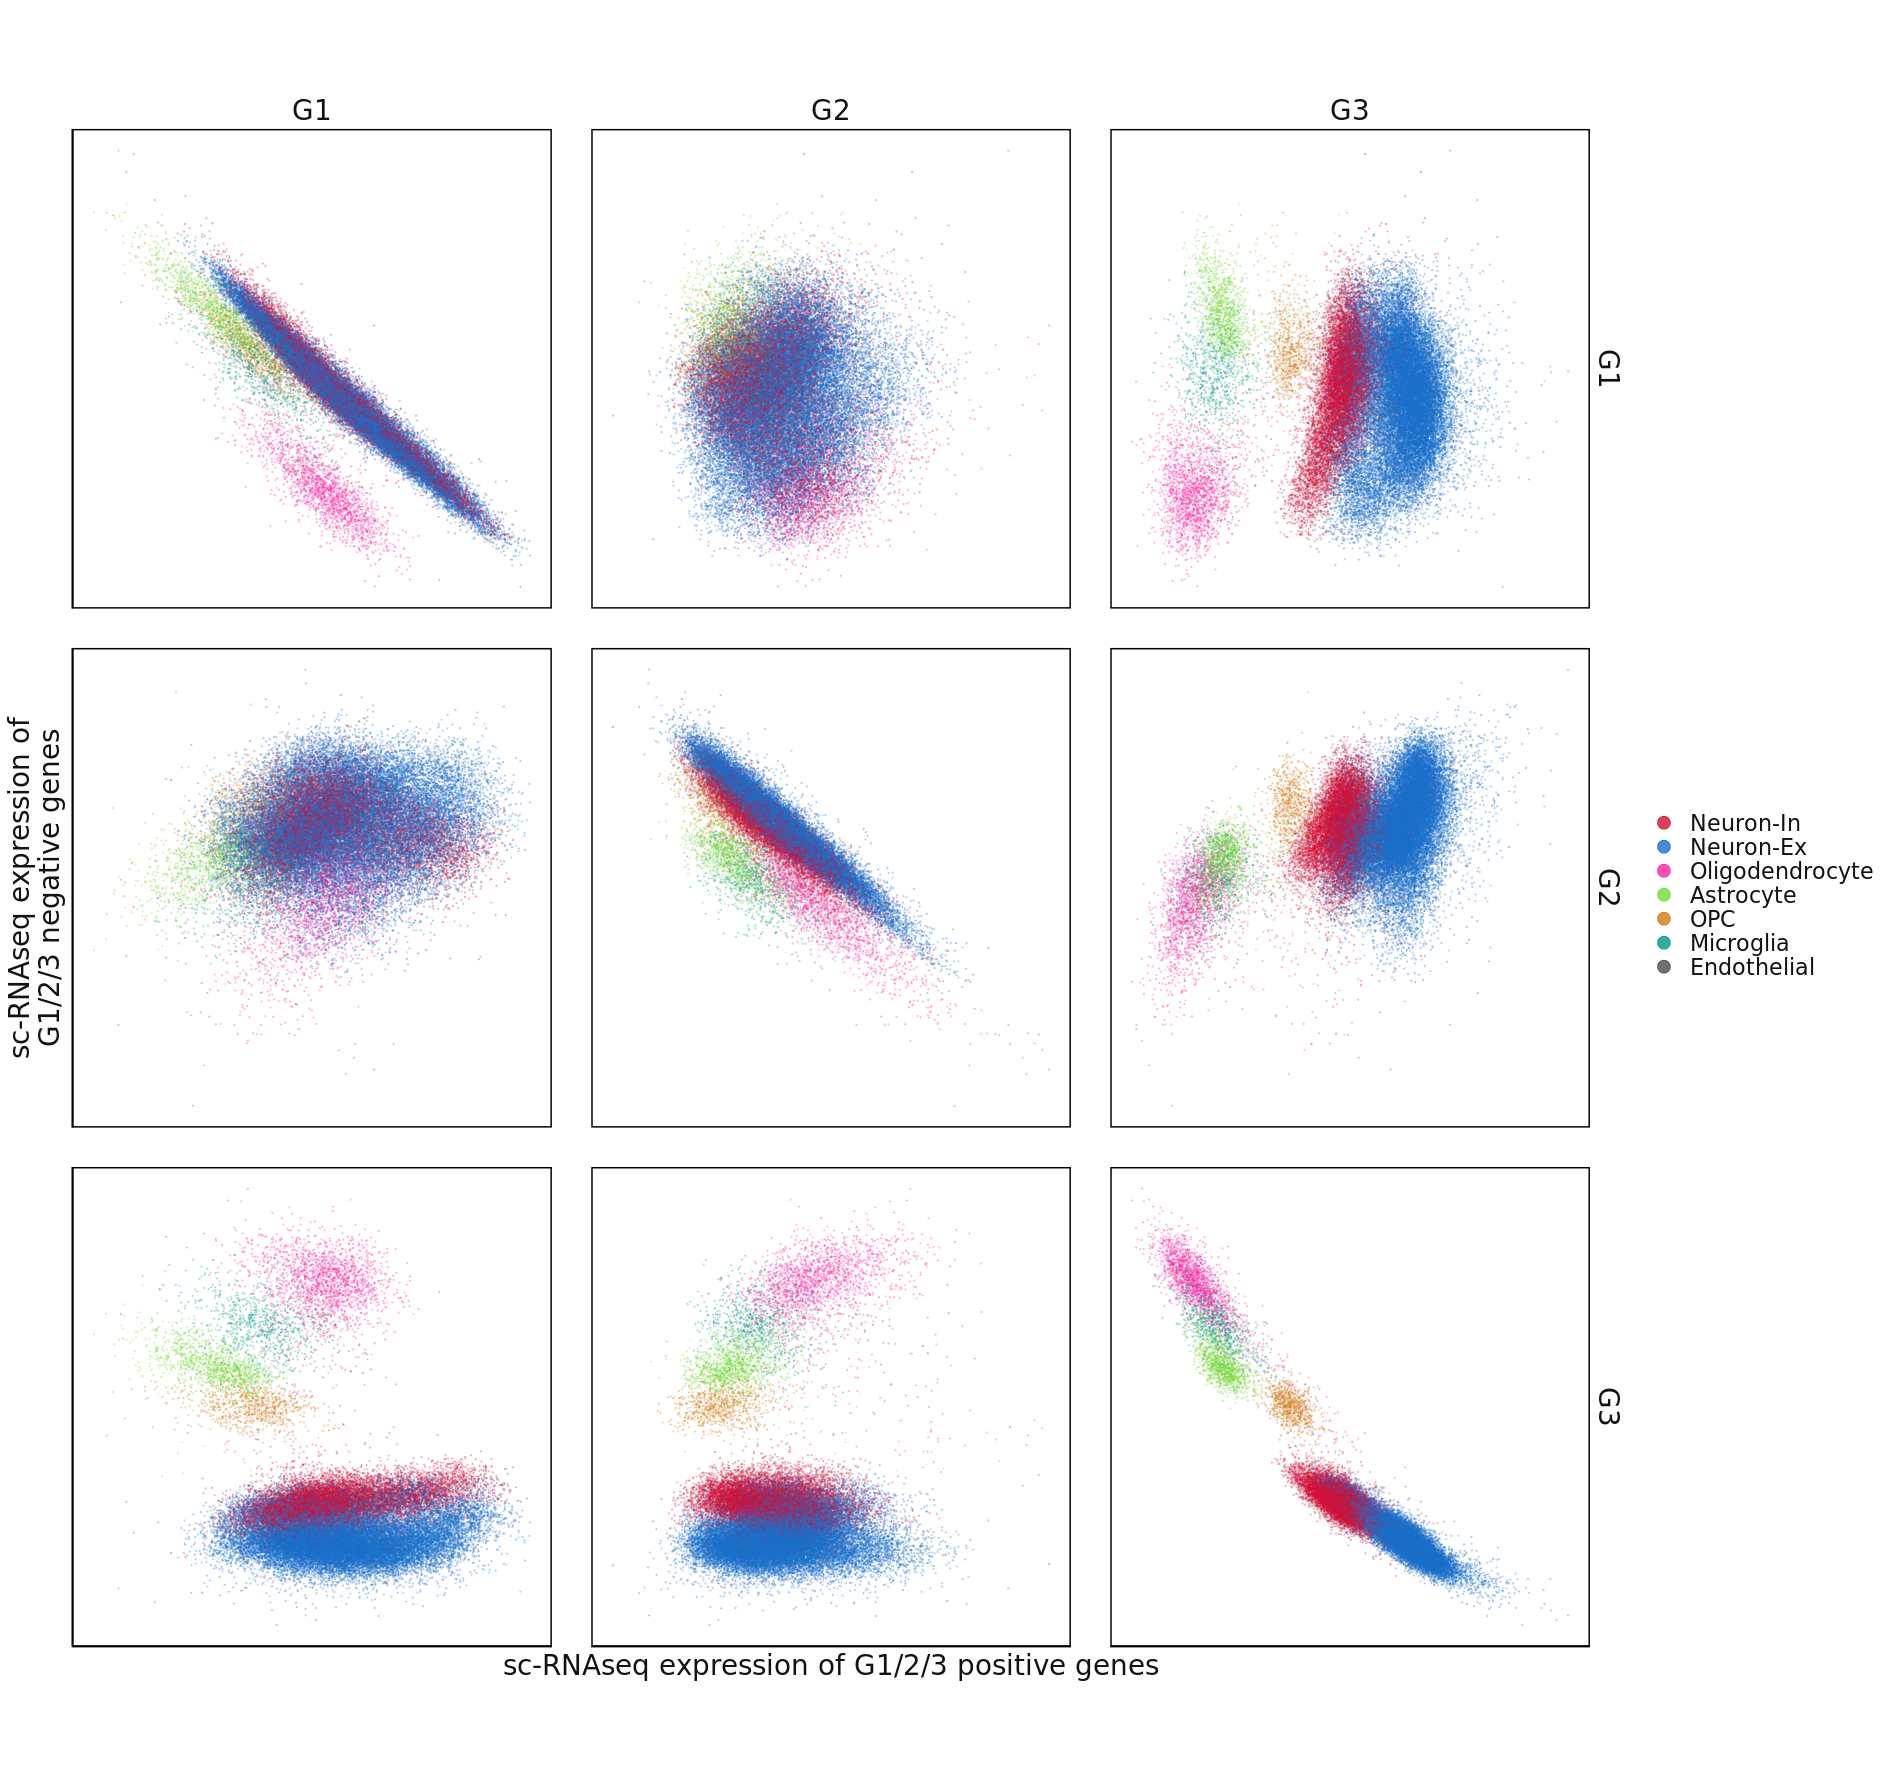

In [33]:
%%R -i sc_axes_cross_plot -w 48 -h 45 -u cm -r 100
colors <- c(
        brewer.rdbu(21)[c(2,20)],
        brewer.piyg(11)[c(2,10)],
        brewer.brbg(11)[c(2,10)]
    ) %>% 
    brightness(scalefac(1.5)) %>% 
    # saturation(scalefac(1.2)) %>% 
    c('grey30')

sc_axes_cross_plot %>% 
mutate(cell_type = factor(cell_type, ordered=T, levels=unique(.$cell_type))) %>% 
ggplot(aes(positive, negative)) + 
facet_grid(G_negative~G_positive, scales='free') + 
geom_point(alpha=.2, size=.2, aes(color=cell_type)) +
xlab("sc-RNAseq expression of G1/2/3 positive genes") +
ylab("sc-RNAseq expression of\nG1/2/3 negative genes") +
scale_color_manual(values=colors, name=NULL) +
# scale_color_manual(values=cols25(10), name=NULL) +
# scale_color_manual(values=viridis(7), name=NULL) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(
    aspect.ratio=1,
    panel.border=element_rect(fill=NA, size=1),
    strip.background = element_blank(),
    panel.grid=element_blank(),
    panel.spacing.x=unit(1,'cm'),
    panel.spacing.y=unit(1,'cm'),
    axis.text=element_blank(),
    axis.ticks=element_blank(),
    text=element_text(size=20, family='Calibri', color='gray7'),
    strip.text=element_text(size=20, family='Calibri', color='gray7')
)


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


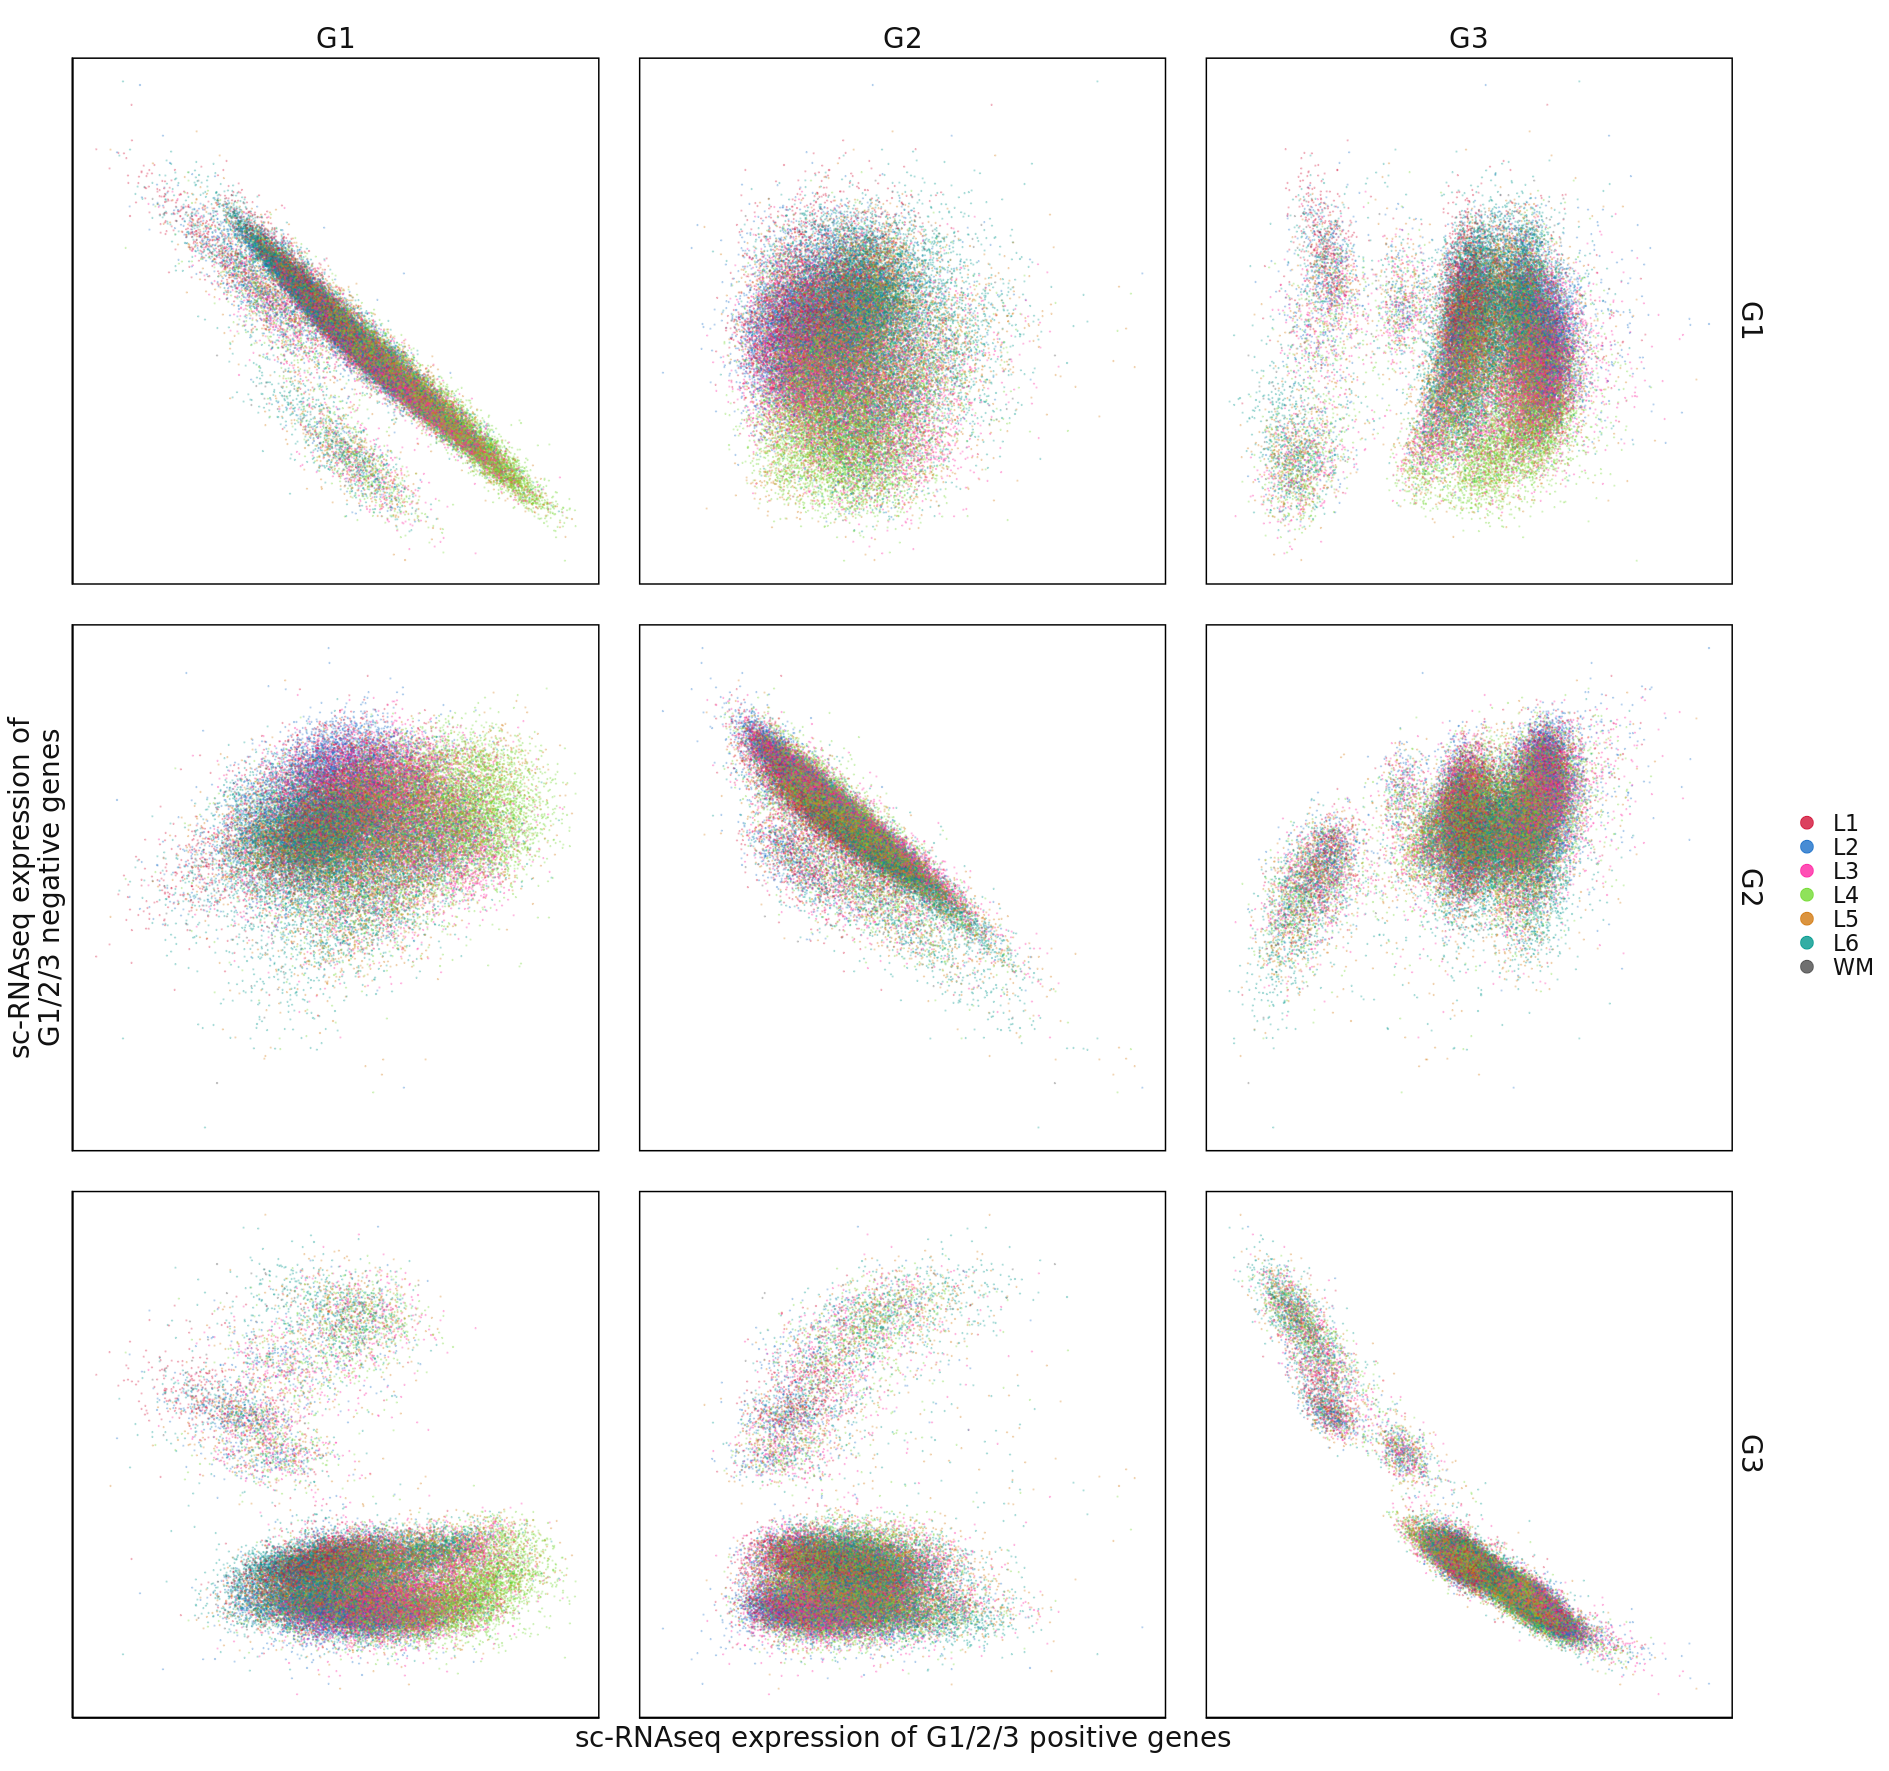

In [34]:
%%R -i sc_axes_cross_plot -w 48 -h 45 -u cm -r 100
colors <- c(
        brewer.rdbu(21)[c(2,20)],
        brewer.piyg(11)[c(2,10)],
        brewer.brbg(11)[c(2,10)]
    ) %>% 
    brightness(scalefac(1.5)) %>% 
    # saturation(scalefac(1.2)) %>% 
    c('grey30')

sc_axes_cross_plot %>% 
mutate(cell_type = factor(cell_type, ordered=T, levels=unique(.$cell_type))) %>% 
ggplot(aes(positive, negative)) + 
facet_grid(G_negative~G_positive, scales='free') + 
geom_point(alpha=.2, size=.2, aes(color=layer)) +
xlab("sc-RNAseq expression of G1/2/3 positive genes") +
ylab("sc-RNAseq expression of\nG1/2/3 negative genes") +
scale_color_manual(values=colors, name=NULL) +
# scale_color_manual(values=cols25(10), name=NULL) +
# scale_color_manual(values=viridis(7), name=NULL) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(
    aspect.ratio=1,
    panel.border=element_rect(fill=NA, size=1),
    strip.background = element_blank(),
    panel.grid=element_blank(),
    panel.spacing.x=unit(1,'cm'),
    panel.spacing.y=unit(1,'cm'),
    axis.text=element_blank(),
    axis.ticks=element_blank(),
    text=element_text(size=20, family='Calibri', color='gray7'),
    strip.text=element_text(size=20, family='Calibri', color='gray7')
)


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


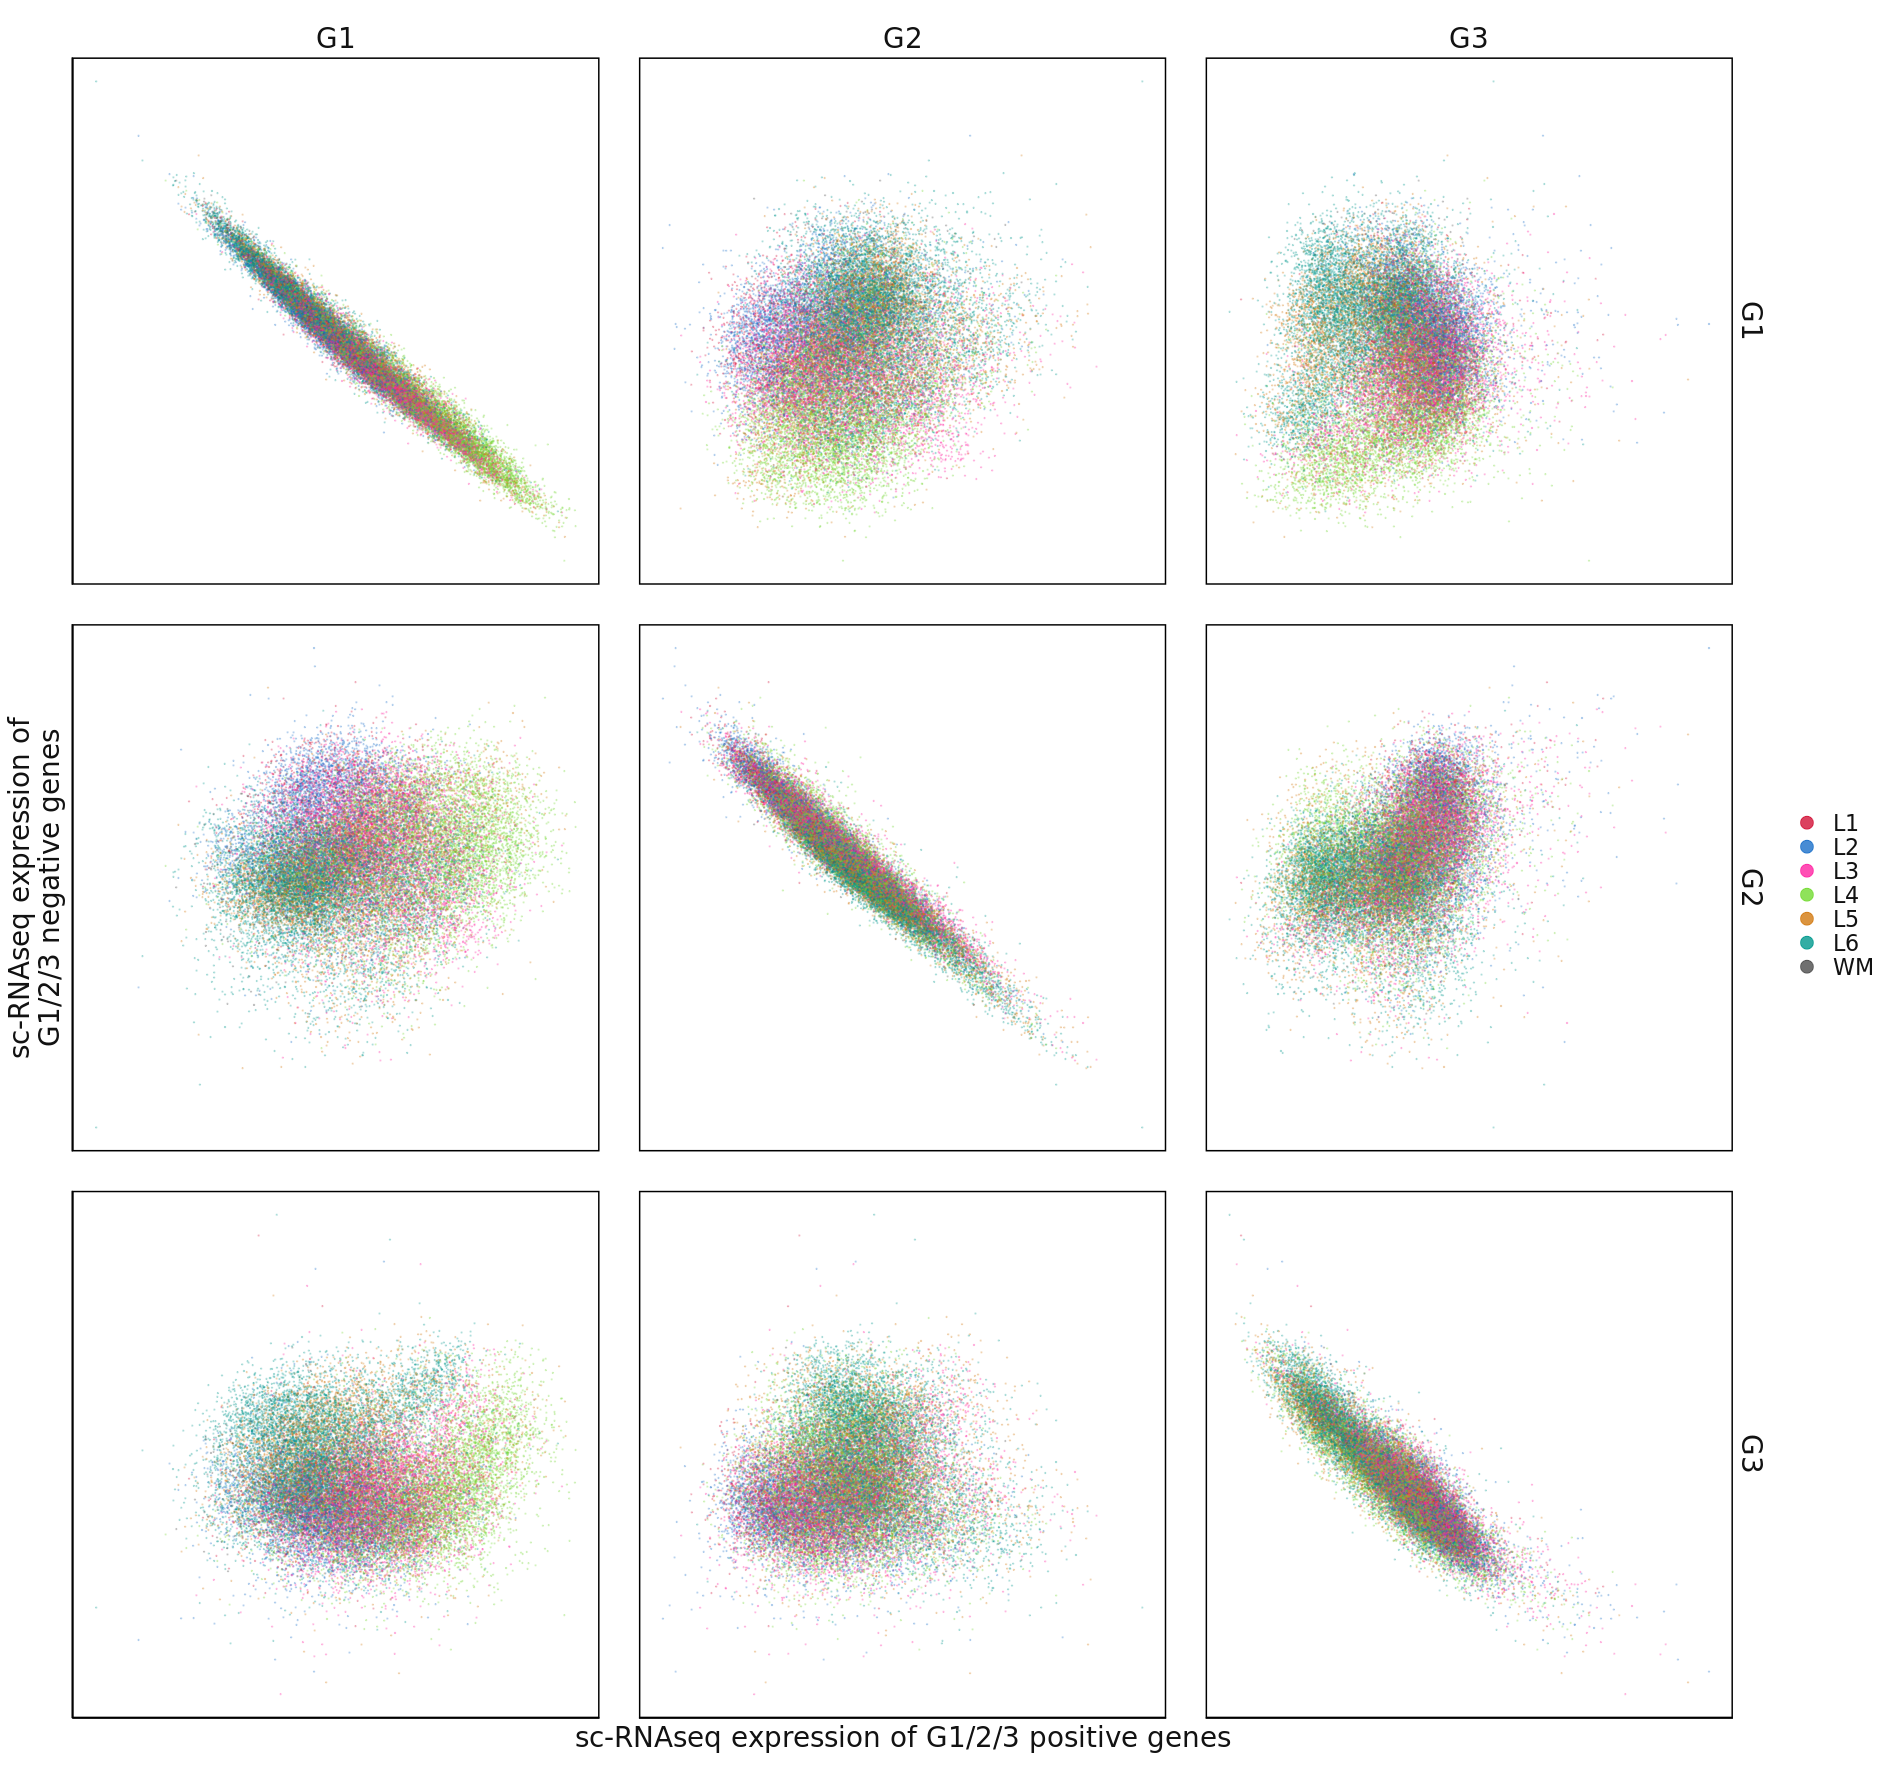

In [35]:
%%R -i sc_axes_cross_plot -w 48 -h 45 -u cm -r 100
colors <- c(
        brewer.rdbu(21)[c(2,20)],
        brewer.piyg(11)[c(2,10)],
        brewer.brbg(11)[c(2,10)]
    ) %>% 
    brightness(scalefac(1.5)) %>% 
    # saturation(scalefac(1.2)) %>% 
    c('grey30')

sc_axes_cross_plot %>% 
mutate(cell_type = factor(cell_type, ordered=T, levels=unique(.$cell_type))) %>% 
filter(cell_type == 'Neuron-Ex') %>% 
ggplot(aes(positive, negative)) + 
facet_grid(G_negative~G_positive, scales='free') + 
geom_point(alpha=.2, size=.2, aes(color=layer)) +
xlab("sc-RNAseq expression of G1/2/3 positive genes") +
ylab("sc-RNAseq expression of\nG1/2/3 negative genes") +
scale_color_manual(values=colors, name=NULL) +
# scale_color_manual(values=cols25(10), name=NULL) +
# scale_color_manual(values=viridis(7), name=NULL) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(
    aspect.ratio=1,
    panel.border=element_rect(fill=NA, size=1),
    strip.background = element_blank(),
    panel.grid=element_blank(),
    panel.spacing.x=unit(1,'cm'),
    panel.spacing.y=unit(1,'cm'),
    axis.text=element_blank(),
    axis.ticks=element_blank(),
    text=element_text(size=20, family='Calibri', color='gray7'),
    strip.text=element_text(size=20, family='Calibri', color='gray7')
)


## PCA/DME on only cell type markers?

In [7]:
cell_genes = get_cell_genes()
cell_genes['label'].unique()

array(['Astro', 'Endo', 'Micro', 'Neuro-Ex', 'Neuro-In', 'OPC', 'Oligo',
       'Synapses'], dtype=object)

In [8]:
cell_genes.groupby('label').count()

gene
label         
Astro     1187
Endo      1253
Micro     1073
Neuro-Ex  1278
Neuro-In   985
OPC        179
Oligo     1208
Synapses  1886

In [9]:
cell_axes = {}
for cell_type in cell_genes['label'].unique():
    cell_gene_filter = cell_genes.loc[lambda x: x['label']==cell_type, 'gene']
    cell_expression = dme_3d_ds5.expression.loc[:, lambda x: np.isin(x.columns, cell_gene_filter)]
    cell_axes[cell_type] = gradientVersion(marker_genes=[]).fit(cell_expression)

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)


In [10]:
cell_axes_weights = {}
for cell_type in cell_genes['label'].unique():
    cell_axes_weights[cell_type] = cell_axes[cell_type].fit_weights(sort=True)

In [124]:
pd.concat(cell_axes_weights, axis=1).to_csv("../outputs/cell_axes_weights.csv")

Weights without cells?

In [37]:
weights_without_cell_type = {}

cell_type_genes = cell_genes.loc[lambda x: np.isin(x['label'], ['Astro','Endo','Micro','Oligo','OPC']), 'gene']
cell_types_genes_matched = np.intersect1d(weights.index, cell_type_genes)
weights_without_cell_type['No glia'] = weights.drop(cell_types_genes_matched, axis=0)

cell_type_genes = cell_genes.loc[lambda x: np.isin(x['label'], ['Neuro-Ex','Neuro-In', 'Synapse']), 'gene']
cell_types_genes_matched = np.intersect1d(weights.index, cell_type_genes)
weights_without_cell_type['No neurons'] = weights.drop(cell_types_genes_matched, axis=0)

for cell_type in cell_genes['label'].unique():
    cell_type_genes = cell_genes.loc[lambda x: x['label']==cell_type, 'gene']
    cell_types_genes_matched = np.intersect1d(weights.index, cell_type_genes)
    weights_without_cell_type[cell_type] = weights.drop(cell_types_genes_matched, axis=0)



In [39]:
pd.concat(weights_without_cell_type, axis=1).to_csv("../outputs/weights_no_cell_types.csv")

In [11]:
scores_melt = (dme_3d_ds5.clean_scores()
               .assign(G1 = lambda x: -x['G1'], G3 = lambda x: -x['G3'])
               .set_index('label').melt(var_name='G', value_name='all')
               .set_index('G', append=True)
                )

cell_scores_join = {}
for cell_type in cell_genes['label'].unique():
    cell_scores_melt = (cell_axes[cell_type].clean_scores()
                        .set_index('label').melt(var_name='G', value_name='cell')
                        .set_index('G', append=True)
                        )

    cell_scores_join[cell_type] = cell_scores_melt.join(scores_melt).reset_index(1)
    # print(cell_scores_join[cell_type].groupby('G').corr().unstack(0).loc['all','cell'].to_frame().T)

cell_scores_plot = pd.concat(cell_scores_join).reset_index(0).rename({'level_0':'cell_type'}, axis=1)

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


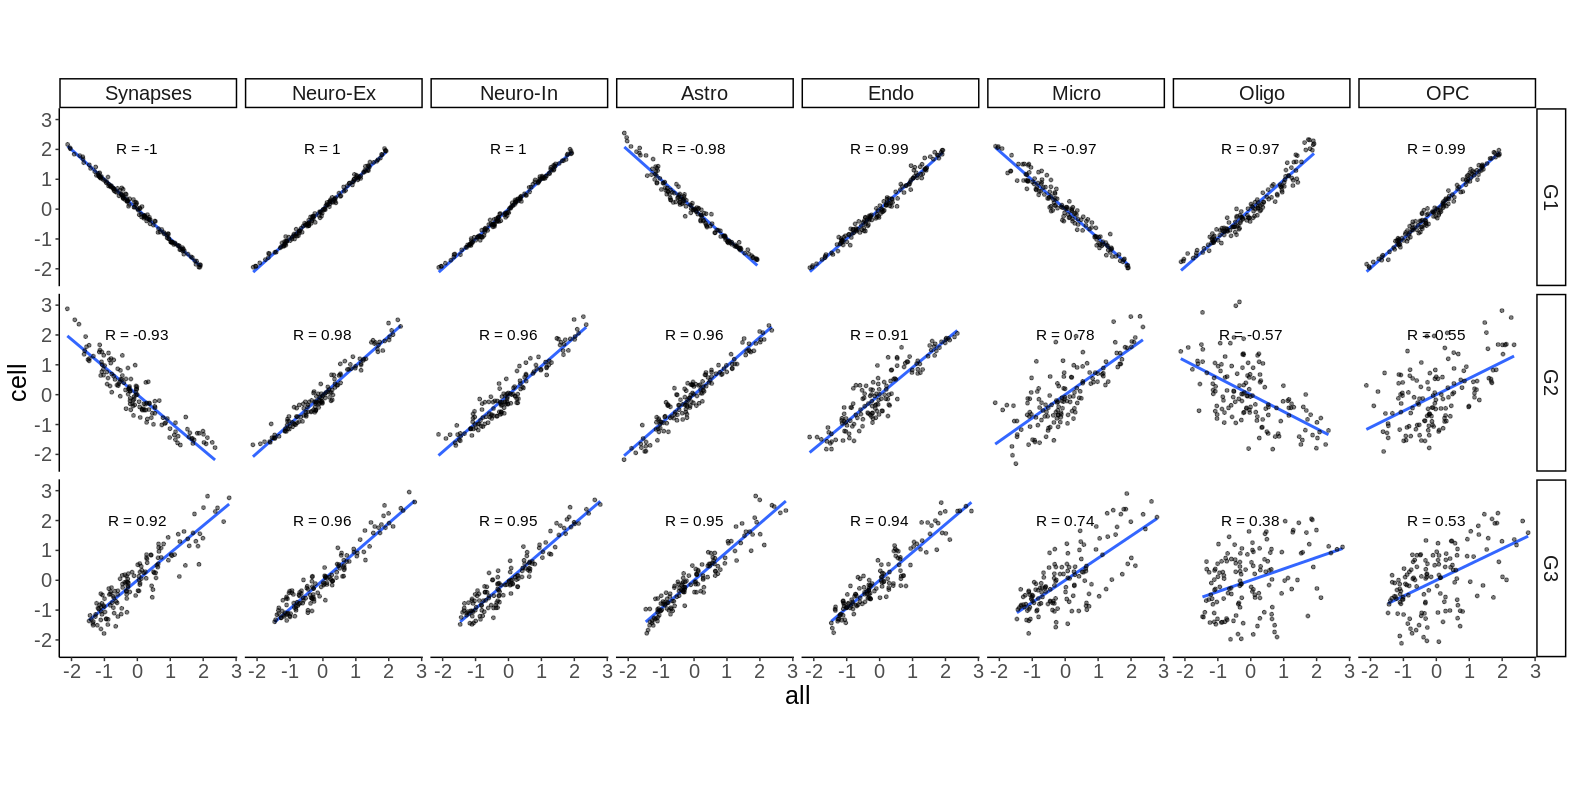

In [14]:
%%R -i cell_scores_plot -w 40 -h 20 -u cm -r 100
order <- c('Synapses','Neuro-Ex','Neuro-In','Astro','Endo','Micro','Oligo','OPC')

cor <- cell_scores_plot %>% 
mutate(cell_type=factor(cell_type, ordered=T, levels=order)) %>% 
group_by(cell_type, G) %>% 
summarise(r=cor(all, cell))

cell_scores_plot %>% 
mutate(cell_type=factor(cell_type, ordered=T, levels=order)) %>% 
ggplot(aes(x=all, y=cell)) + 
facet_grid(G~cell_type) +
geom_smooth(method='lm', se=F) +
geom_point(size=1, alpha=.5) + 
geom_text(data=cor, aes(label=paste("R =", round(r,2))), x=0, y=2) +
theme_classic() + 
theme(
    aspect.ratio=1,
    strip.text=element_text(angle=0),
    text=element_text(size=18)
)

## See if positive and negative genes are anticorrelated

In [22]:
metadata = pd.read_csv("../data/allen_single_cell_metadata.csv") 
metadata['cell_type'] = np.where(metadata['class_label']=='Non-neuronal', metadata['subclass_label'], 
                                 metadata['class_label'].map({'Glutamatergic':'Neuro-Ex','GABAergic':'Neuro-In'}))
metadata['layer'] = metadata['cortical_layer_label'].str[:2]
metadata.head()

sample_name   exp_component_name specimen_type cluster_color  \
0  F2S4_160113_027_A01  LS-15005h_S01_E1-50       nucleus           NaN   
1  F2S4_160113_027_B01  LS-15005h_S02_E1-50       nucleus       #E170FE   
2  F2S4_160113_027_C01  LS-15005h_S03_E1-50       nucleus       #8E5864   
3  F2S4_160113_027_D01  LS-15005h_S04_E1-50       nucleus       #8B5862   
4  F2S4_160113_027_E01  LS-15005h_S05_E1-50       nucleus       #CF6EC9   

   cluster_order          cluster_label class_color  class_order class_label  \
0            NaN                    NaN         NaN          NaN         NaN   
1           32.0      Inh L2-5 VIP TOX2     #0066FF          4.0   GABAergic   
2            2.0     Inh L1 LAMP5 GGT8P     #0066FF          4.0   GABAergic   
3            1.0      Inh L1 LAMP5 NDNF     #0066FF          4.0   GABAergic   
4           34.0  Inh L1-3 VIP ZNF322P1     #0066FF          4.0   GABAergic   

  subclass_color  ...  cell_type_designation_color  \
0            NaN  ...                          NaN   
1        #996517  ...                      #E170FE   
2        #FF7373  ...                      #8E5864   
3        #FF7373  ...                      #8B5862   
4        #996517  ...                      #CF6EC9   

  cell_type_designation_order  cell_type_designation_label  \
0                         NaN                          NaN   
1                        32.0                   Neuron 032   
2                         2.0                   Neuron 002   
3                         1.0                   Neuron 001   
4                        34.0                   Neuron 034   

   external_donor_name_color  external_donor_name_order  \
0                    #3DCC3D                          2   
1                    #3DCC3D                          2   
2                    #3DCC3D                          2   
3                    #3DCC3D                          2   
4                    #3DCC3D                          2   

  external_donor_name_label  outlier_call              outlier_type cell_type  \
0                 H200.1025          True  Outlier L1-3 SST OR2AD1P       NaN   
1                 H200.1025         False                       NaN  Neuro-In   
2                 H200.1025         False                       NaN  Neuro-In   
3                 H200.1025         False                       NaN  Neuro-In   
4                 H200.1025         False                       NaN  Neuro-In   

   layer  
0     L1  
1     L1  
2     L1  
3     L1  
4     L1  

[5 rows x 43 columns]

In [155]:
sc_axes_posneg.corr()

G1-       G2-       G3-       G1+       G2+       G3+
G1-  1.000000 -0.100991  0.088440 -0.895035 -0.004305 -0.141176
G2- -0.100991  1.000000  0.436201  0.183322 -0.853761 -0.401640
G3-  0.088440  0.436201  1.000000  0.210929 -0.065352 -0.945557
G1+ -0.895035  0.183322  0.210929  1.000000  0.031333 -0.236350
G2+ -0.004305 -0.853761 -0.065352  0.031333  1.000000  0.014630
G3+ -0.141176 -0.401640 -0.945557 -0.236350  0.014630  1.000000

In [157]:
sc_axes_posneg1000.corr()

G1-       G2-       G3-       G1+       G2+       G3+
G1-  1.000000 -0.035244  0.269382 -0.522607  0.092978 -0.359966
G2- -0.035244  1.000000  0.446615  0.263243 -0.621910 -0.400188
G3-  0.269382  0.446615  1.000000  0.364338  0.116011 -0.878910
G1+ -0.522607  0.263243  0.364338  1.000000  0.141687 -0.480257
G2+  0.092978 -0.621910  0.116011  0.141687  1.000000 -0.224873
G3+ -0.359966 -0.400188 -0.878910 -0.480257 -0.224873  1.000000

In [158]:
sc_axes_posneg_r04.corr()

G1-       G2-       G3-       G1+       G2+       G3+
G1-  1.000000 -0.155357  0.048799 -0.786966  0.062702 -0.173237
G2- -0.155357  1.000000  0.432498  0.232617 -0.563257 -0.388629
G3-  0.048799  0.432498  1.000000  0.267915  0.168505 -0.791733
G1+ -0.786966  0.232617  0.267915  1.000000  0.139064 -0.382064
G2+  0.062702 -0.563257  0.168505  0.139064  1.000000 -0.293696
G3+ -0.173237 -0.388629 -0.791733 -0.382064 -0.293696  1.000000

In [108]:
metadata.columns

Index(['sample_name', 'exp_component_name', 'specimen_type', 'cluster_color',
       'cluster_order', 'cluster_label', 'class_color', 'class_order',
       'class_label', 'subclass_color', 'subclass_order', 'subclass_label',
       'full_genotype_color', 'full_genotype_order', 'full_genotype_label',
       'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color',
       'region_order', 'region_label', 'cortical_layer_color',
       'cortical_layer_order', 'cortical_layer_label',
       'cell_type_accession_color', 'cell_type_accession_order',
       'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order',
       'cell_type_alias_label', 'cell_type_alt_alias_color',
       'cell_type_alt_alias_order', 'cell_type_alt_alias_label',
       'cell_type_designation_color', 'cell_type_designation_order',
       'cell_type_designation_label', 'external_donor_name_color',
       'external_donor_name_order', 'external_donor_name_label',
       'outlier_call', 'outli

In [161]:
# sc_axes_posneg_plot = pd.concat([
#     sc_axes_posneg.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1).melt(var_name='G',value_name='neg'),
#     sc_axes_posneg.iloc[:,3:].set_axis(['G1','G2','G3'],axis=1).melt(var_name='G',value_name='pos').drop('G', axis=1)
# ], axis=1)

sc_axes_pos = sc_axes_posneg_r04.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1).stack().rename('negative')
sc_axes_neg = sc_axes_posneg_r04.iloc[:,3:].set_axis(['G1','G2','G3'],axis=1).stack().rename('positive')
sc_axes_melt = sc_axes_pos.to_frame().join(sc_axes_neg).reset_index(1).rename({'level_1':'G'}, axis=1)

sc_axes_posneg_plot = (
    metadata.loc[:,['class_label','subclass_label','region_label','layer','cell_type','outlier_call']]
    .join(sc_axes_melt)
    .query("~outlier_call")
)


sc_axes_posneg_plot

class_label   subclass_label region_label layer        cell_type  \
1         GABAergic              VIP          MTG    L1         Neuro-In   
1         GABAergic              VIP          MTG    L1         Neuro-In   
1         GABAergic              VIP          MTG    L1         Neuro-In   
2         GABAergic            LAMP5          MTG    L1         Neuro-In   
2         GABAergic            LAMP5          MTG    L1         Neuro-In   
...             ...              ...          ...   ...              ...   
49415  Non-neuronal  Oligodendrocyte          A1C    WM  Oligodendrocyte   
49415  Non-neuronal  Oligodendrocyte          A1C    WM  Oligodendrocyte   
49416  Non-neuronal  Oligodendrocyte          A1C    WM  Oligodendrocyte   
49416  Non-neuronal  Oligodendrocyte          A1C    WM  Oligodendrocyte   
49416  Non-neuronal  Oligodendrocyte          A1C    WM  Oligodendrocyte   

       outlier_call   G     negative     positive  
1             False  G1  2071.009686  1801.986832  
1             False  G2   497.067683   439.117163  
1             False  G3   300.385146   135.585147  
2             False  G1  1823.983027  1945.160342  
2             False  G2   506.920582   418.010426  
...             ...  ..          ...          ...  
49415         False  G2   397.501718   428.558859  
49415         False  G3   212.097816   455.357497  
49416         False  G1  1744.999376  1655.900772  
49416         False  G2   425.312059   464.682690  
49416         False  G3   182.471760   482.143057  

[142296 rows x 9 columns]

In [140]:
# sc_axes_posneg_plot['cell_type'].value_counts()
# sc_axes_posneg_plot['subclass_label'].value_counts()

IT                 65523
L4 IT              11175
VIP                10599
PVALB               8400
L6 CT               7668
LAMP5               7302
SST                 7074
Oligodendrocyte     5790
Astrocyte           3561
L6b                 3240
L5/6 IT Car3        3159
L5/6 NP             2448
OPC                 2319
Microglia           2250
PAX6                 975
L5 ET                474
Endothelial          210
Pericyte              96
VLMC                  33
Name: subclass_label, dtype: int64

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


[1] 2799


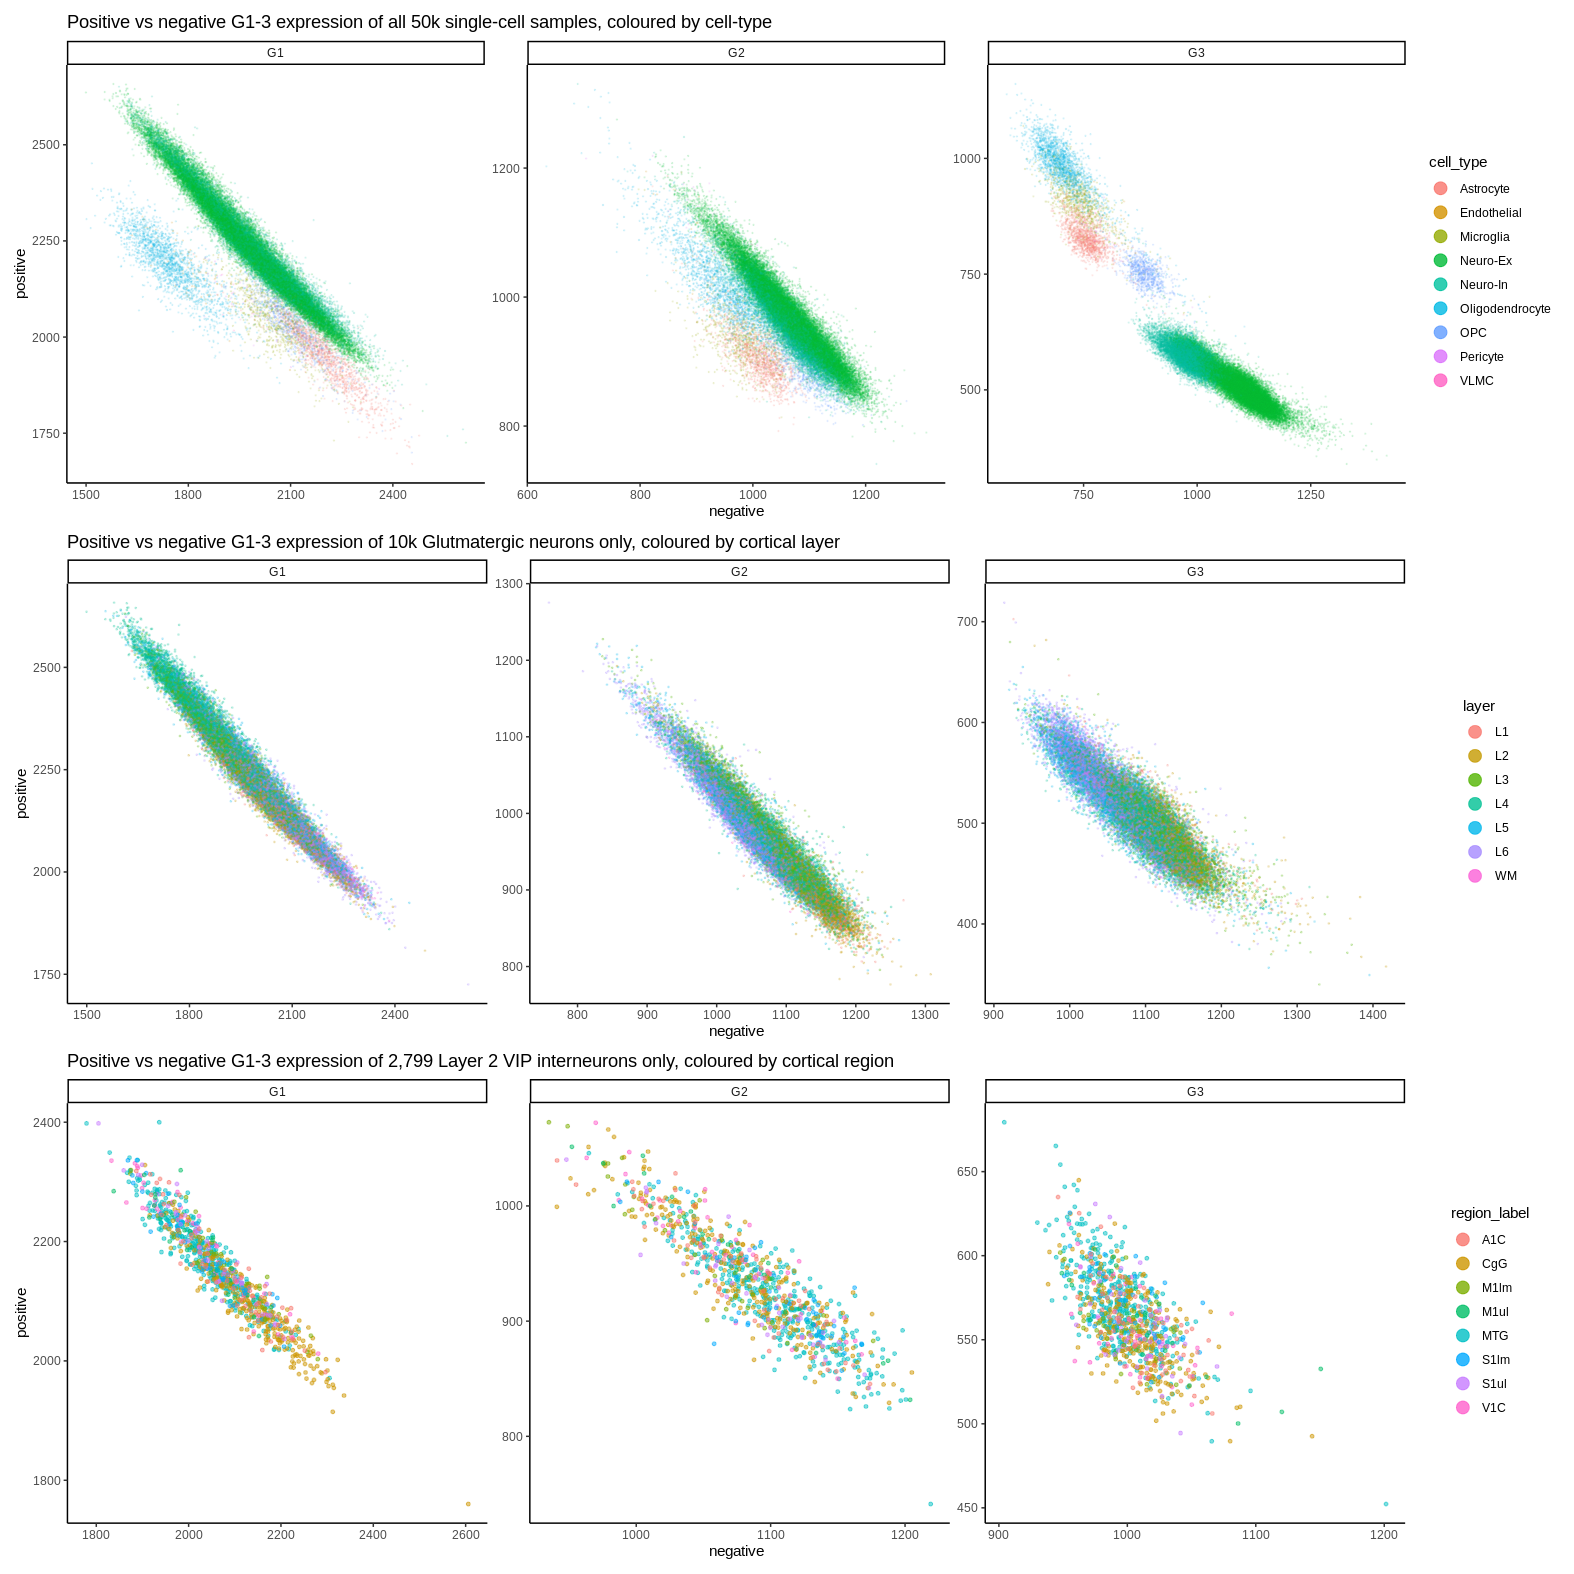

In [ ]:
%%R -i sc_axes_posneg_plot -w 40 -h 40 -u cm -r 100

g1 <- sc_axes_posneg_plot %>% 
# filter(region_label == 'A1C') %>%  
ggplot(aes(negative, positive)) + 
facet_wrap(~G, scales='free') + 
geom_point(alpha=.1, size=.2, 
    aes(color=cell_type)) + 
    # aes(color=layer)) + 
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(aspect.ratio=1) + 
ggtitle('Positive vs negative G1-3 expression of all 50k single-cell samples, coloured by cell-type')

g2 <- sc_axes_posneg_plot %>% 
# filter(region_label == 'A1C') %>% 
filter(cell_type == 'Neuro-Ex') %>% 
ggplot(aes(negative, positive)) + 
facet_wrap(~G, scales='free') + 
geom_point(alpha=.2, size=.3, 
    # aes(color=cell_type)) + 
    aes(color=layer)) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(aspect.ratio=1) +
ggtitle('Positive vs negative G1-3 expression of 10k Glutmatergic neurons only, coloured by cortical layer')

g3 <- sc_axes_posneg_plot %>% 
# filter(region_label == 'A1C') %>% 
# filter(cell_type == 'Neuro-Ex') %>% 
# filter(subclass_label %in% c('SST','PVALB')) %>% 
filter(layer == 'L2') %>% 
filter(subclass_label == 'VIP') %>% 
ggplot(aes(negative, positive)) + 
facet_wrap(~G, scales='free') + 
geom_point(alpha=.5, size=1, 
    # aes(color=subclass_label)) + 
    aes(color=region_label)) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(aspect.ratio=1) +
# ggtitle('Positive vs negative G1-3 expression of 8,400 PVALB and 7,074 SST interneurons only')
ggtitle('Positive vs negative G1-3 expression of 2,799 Layer 2 VIP interneurons only, coloured by cortical region')
 
sc_axes_posneg_plot %>% 
filter(layer == 'L2') %>% 
filter(subclass_label == 'VIP') %>% nrow() %>% print

g1 / g2 / g3

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


[1] 2799


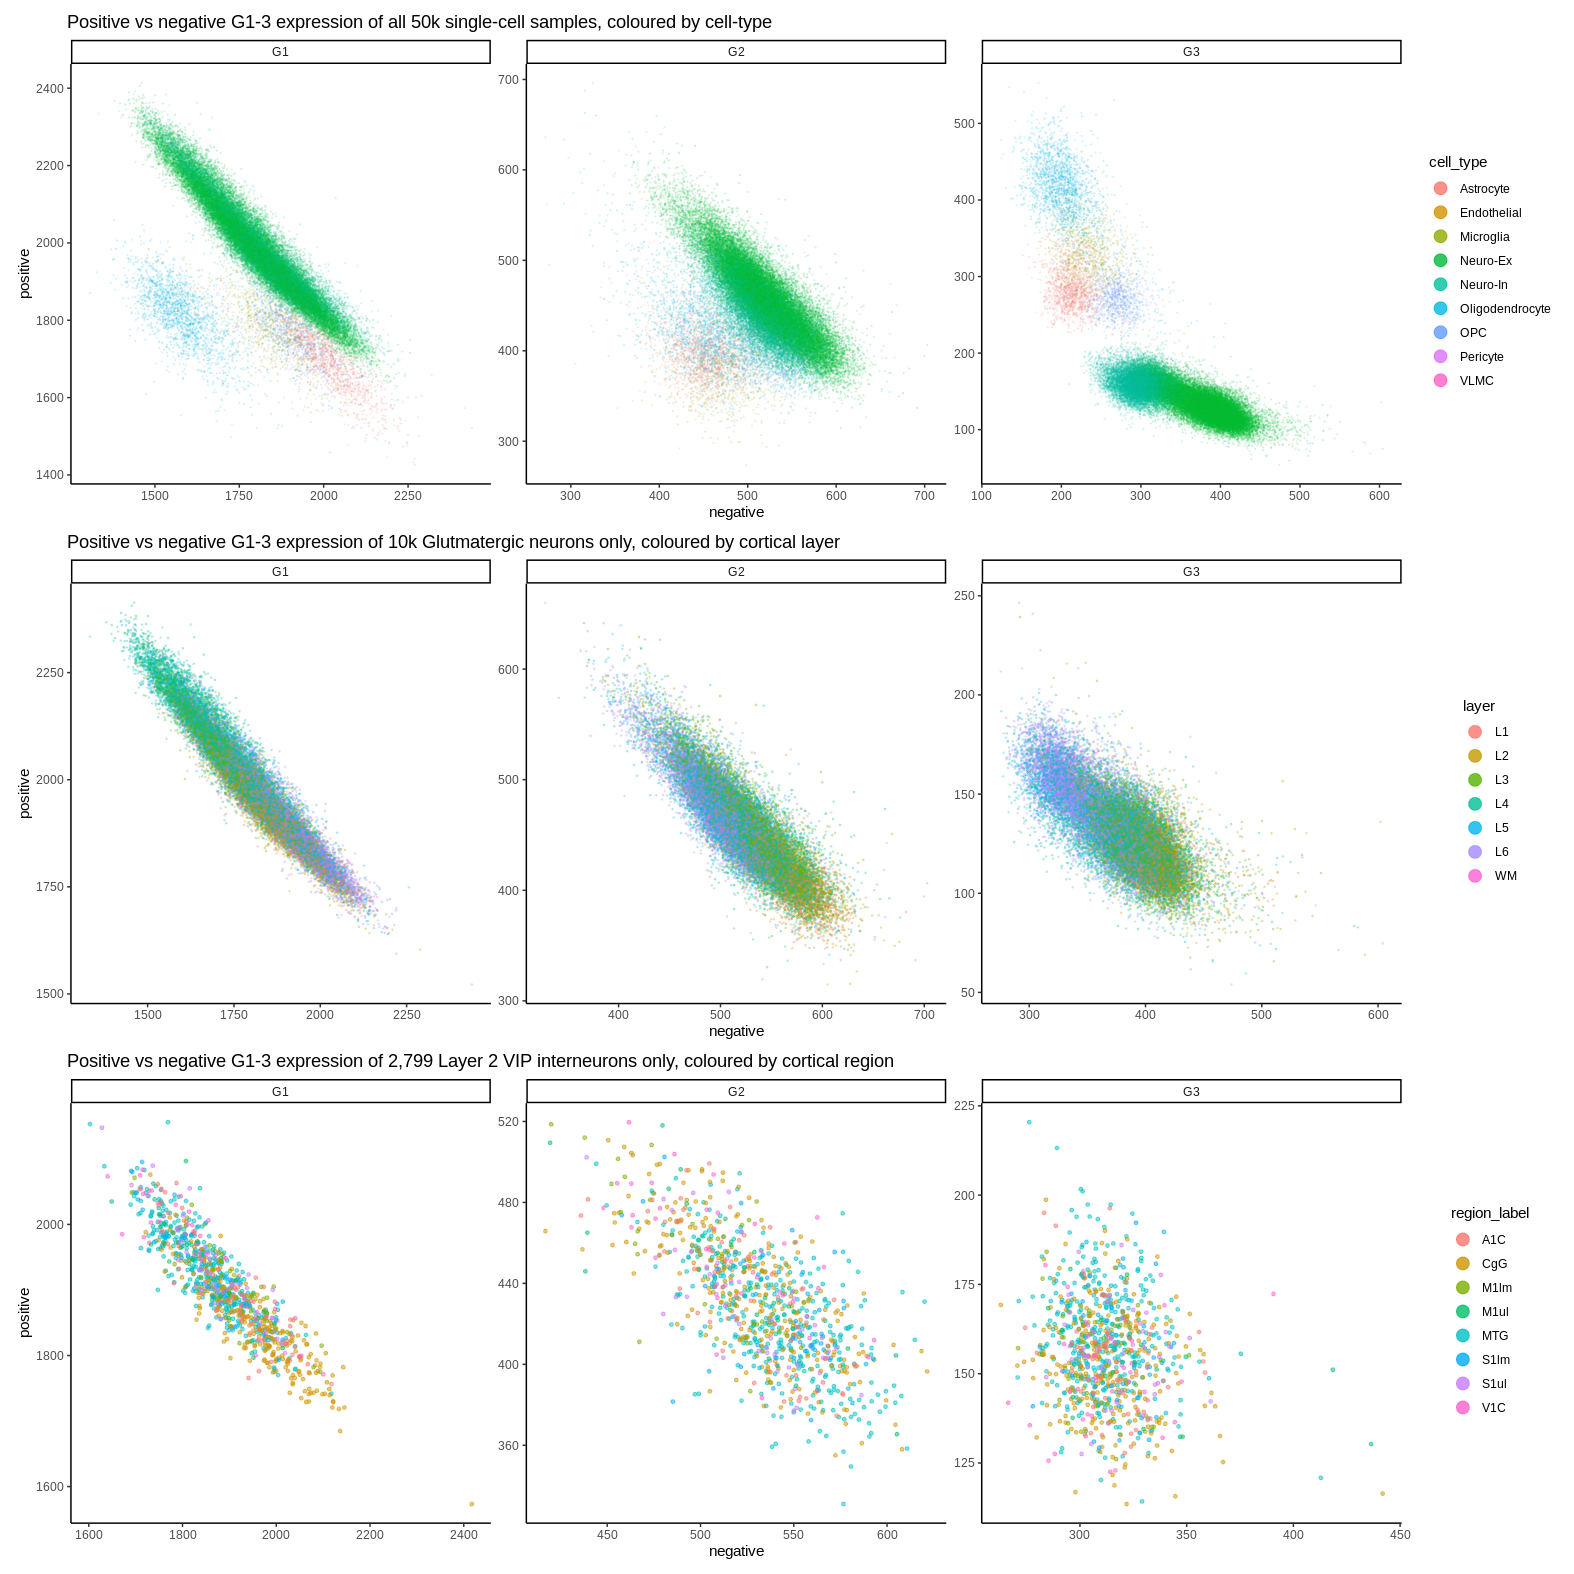

In [ ]:
%%R -i sc_axes_posneg_plot -w 40 -h 40 -u cm -r 100

g1 <- sc_axes_posneg_plot %>% 
# filter(region_label == 'A1C') %>%  
ggplot(aes(negative, positive)) + 
facet_wrap(~G, scales='free') + 
geom_point(alpha=.1, size=.2, 
    aes(color=cell_type)) + 
    # aes(color=layer)) + 
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(aspect.ratio=1) + 
ggtitle('Positive vs negative G1-3 expression of all 50k single-cell samples, coloured by cell-type')

g2 <- sc_axes_posneg_plot %>% 
# filter(region_label == 'A1C') %>% 
filter(cell_type == 'Neuro-Ex') %>% 
ggplot(aes(negative, positive)) + 
facet_wrap(~G, scales='free') + 
geom_point(alpha=.2, size=.3, 
    # aes(color=cell_type)) + 
    aes(color=layer)) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(aspect.ratio=1) +
ggtitle('Positive vs negative G1-3 expression of 10k Glutmatergic neurons only, coloured by cortical layer')

g3 <- sc_axes_posneg_plot %>% 
# filter(region_label == 'A1C') %>% 
# filter(cell_type == 'Neuro-Ex') %>% 
# filter(subclass_label %in% c('SST','PVALB')) %>% 
filter(layer == 'L2') %>% 
filter(subclass_label == 'VIP') %>% 
ggplot(aes(negative, positive)) + 
facet_wrap(~G, scales='free') + 
geom_point(alpha=.5, size=1, 
    # aes(color=subclass_label)) + 
    aes(color=region_label)) +
guides(colour = guide_legend(override.aes = list(size=4, alpha=.8))) +
theme_classic() + 
theme(aspect.ratio=1) +
# ggtitle('Positive vs negative G1-3 expression of 8,400 PVALB and 7,074 SST interneurons only')
ggtitle('Positive vs negative G1-3 expression of 2,799 Layer 2 VIP interneurons only, coloured by cortical region')
 
sc_axes_posneg_plot %>% 
filter(layer == 'L2') %>% 
filter(subclass_label == 'VIP') %>% nrow() %>% print

g1 / g2 / g3

## Try correlating matched regions?

In [19]:
metadata = pd.read_csv("../data/allen_single_cell_metadata.csv")

region_mapping = {
    'V1C':'V1',
    'M1ul':'4',
    'M1lm':'4',
    'S1ul':'1',
    'S1lm':'1',
    'A1C':'A1',
    'MTG':'TE1m',
    'CgG':'a24'
}

metadata['region'] = metadata['region_label'].map(region_mapping)
metadata['cell_type'] = np.where(metadata['class_label']=='Non-neuronal', metadata['subclass_label'], 
                                 metadata['class_label'].map({'Glutamatergic':'Neuro-Ex','GABAergic':'Neuro-In'}))

In [23]:
sc = (pd.read_csv("../data/allen_single_cell_G123_log10.csv", index_col=0)
      .set_axis(['G1','G2','G3'], axis=1)
      .join(metadata[['class_label','region']])
      .loc[metadata['outlier_call']==False, :]
      .loc[metadata['cortical_layer_label']!='WM', :]
      .groupby(['class_label', 'region'])
      .mean()
      .groupby('class_label')
      .apply(lambda x: (x-np.mean(x))/np.std(x))
      .melt(ignore_index=False, var_name='G', value_name='sc_score')
      .set_index('G', append=True)
      )
sc.head()
# sc.shape

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


sc_score
class_label region G           
GABAergic   1      G1  0.174784
            4      G1  0.100168
            A1     G1 -0.311225
            TE1m   G1 -0.169481
            V1     G1  1.807674

In [42]:
(sc.join(scores.rename({'label':'region'}, axis=1).set_index(['G','region']))
    .sort_values(['G','class_label'])
    .reset_index().loc[lambda x: x['region']!='TE1m']
#  .reset_index().loc[lambda x: x['cortical_layer_label']=='L4']
    .groupby(['G','class_label']).corr()
    .loc[pd.IndexSlice[:,:,'sc_score'],'G_score']
    .unstack(0)
)

G                             G1        G2        G3
class_label                                         
GABAergic     sc_score  0.841134 -0.079040  0.138260
Glutamatergic sc_score  0.901972  0.610832  0.444402
Non-neuronal  sc_score  0.901371  0.650857  0.582940

In [36]:
pd.read_csv("../data/allen_single_cell_matrix.csv", nrows=10, usecols=matching_column_indices).add(1).pipe(np.log10)

A1BG  A1BG-AS1      AAAS  AAED1     AAGAB      AAK1      AARD  \
0  0.000000       0.0  0.000000    0.0  0.000000  2.806180  0.000000   
1  2.075547       0.0  0.301030    0.0  2.840106  2.663701  0.000000   
2  0.000000       0.0  0.000000    0.0  0.000000  2.995196  1.770852   
3  2.204120       0.0  0.000000    0.0  0.000000  2.178977  0.000000   
4  0.301030       0.0  0.000000    0.0  0.301030  2.313867  0.000000   
5  1.041393       0.0  0.000000    0.0  0.000000  2.460898  0.000000   
6  0.000000       0.0  0.000000    0.0  1.176091  2.746634  0.000000   
7  0.301030       0.0  0.000000    0.0  2.161368  2.588832  0.000000   
8  0.000000       0.0  0.477121    0.0  2.000000  2.634477  0.000000   
9  0.000000       0.0  0.000000    0.0  1.342423  1.832509  0.000000   

       AARS     AASDH      AATF  ...   ZSCAN29   ZSCAN31  ZSCAN5A  ZSCAN9  \
0  0.301030  0.778151  0.000000  ...  1.447158  0.301030      0.0     0.0   
1  2.617000  0.000000  0.000000  ...  0.000000  0.000000      0.0     0.0   
2  0.698970  0.301030  0.000000  ...  0.000000  0.301030      0.0     0.0   
3  1.799341  2.278754  0.698970  ...  0.000000  0.000000      0.0     0.0   
4  1.869232  2.350248  0.000000  ...  0.000000  1.041393      0.0     0.0   
5  2.332438  0.301030  0.000000  ...  0.301030  2.079181      0.0     0.0   
6  0.477121  0.301030  0.000000  ...  0.000000  1.000000      0.0     0.0   
7  0.000000  2.143015  0.000000  ...  0.000000  0.000000      0.0     0.0   
8  0.000000  2.017033  1.431364  ...  0.000000  2.720986      0.0     0.0   
9  1.041393  0.301030  0.000000  ...  0.000000  0.000000      0.0     0.0   

    ZSWIM4    ZSWIM7  ZWINT       ZYX     ZZEF1      ZZZ3  
0  0.00000  0.301030    0.0  1.623249  2.652246  0.000000  
1  0.30103  2.049218    0.0  0.000000  0.000000  2.874482  
2  0.00000  0.000000    0.0  0.000000  2.012837  0.000000  
3  0.00000  0.000000    0.0  0.000000  0.602060  0.301030  
4  0.00000  0.000000    0.0  0.000000  0.698970  1.531479  
5  0.00000  1.041393    0.0  0.000000  0.954243  2.518514  
6  0.00000  1.146128    0.0  0.000000  1.361728  0.000000  
7  0.00000  0.000000    0.0  0.000000  1.897627  2.173186  
8  0.60206  0.000000    0.0  1.857332  1.959041  2.264818  
9  0.00000  0.000000    0.0  1.778151  0.778151  1.845098  

[10 rows x 7707 columns]

In [119]:
metadata.groupby(['region_label','cell_type'])['sample_name'].count().unstack(0)

region_label        A1C     CgG    M1lm    M1ul      MTG    S1lm    S1ul  \
cell_type                                                                  
Astrocyte         187.0   262.0   133.0    58.0    373.0    55.0    60.0   
Endothelial         7.0     6.0     8.0     3.0     18.0     9.0    13.0   
Microglia         130.0   106.0    47.0    37.0    246.0    64.0    64.0   
Neuro-Ex         4038.0  3281.0  1993.0  1601.0  10324.0  1743.0  1877.0   
Neuro-In         1690.0  1936.0   787.0   793.0   3784.0   647.0   836.0   
OPC                97.0   155.0    46.0    30.0    255.0    46.0    41.0   
Oligodendrocyte   316.0   189.0   195.0   219.0    501.0   119.0   118.0   
Pericyte            4.0     2.0     3.0     1.0     13.0     2.0     3.0   
VLMC                1.0     2.0     1.0     NaN      5.0     NaN     1.0   

region_label        V1C  
cell_type                
Astrocyte          59.0  
Endothelial         6.0  
Microglia          56.0  
Neuro-Ex         6372.0  
Neuro-In          977.0  
OPC               103.0  
Oligodendrocyte   273.0  
Pericyte            4.0  
VLMC                1.0

## Project to G123 by positive and negative (do once)

In [5]:
genes_to_match = set(weights.index)
all_columns = pd.read_csv("../data/allen_single_cell_matrix.csv", nrows=1).columns
matching_column_indices = [i for i, e in enumerate(all_columns) if e in genes_to_match]

weights_matched = weights.loc[list(set(all_columns).intersection(genes_to_match)),:]

In [6]:
weights_posneg = pd.concat([
    weights_matched.applymap(lambda x: np.where(x<0, -x, 0)).set_axis([f'G{i+1}-' for i in range(3)], axis=1),
    weights_matched.applymap(lambda x: np.where(x>0, x, 0)).set_axis([f'G{i+1}+' for i in range(3)], axis=1)
], axis=1)
weights_posneg

G1-       G2-       G3-       G1+       G2+       G3+
DPY19L2P3  0.000000  0.594771  0.000000  0.544804  0.000000  0.089578
TBC1D19    0.000000  0.000000  0.000000  0.743774  0.156673  0.000995
PART1      0.000000  0.000000  0.000000  0.230310  0.554795  0.405211
SMIM14     0.406463  0.404614  0.120312  0.000000  0.000000  0.000000
WNT4       0.720263  0.177166  0.088412  0.000000  0.000000  0.000000
...             ...       ...       ...       ...       ...       ...
PARP2      0.000000  0.538298  0.000000  0.026153  0.000000  0.378087
HDAC4      0.000000  0.450728  0.116674  0.390439  0.000000  0.000000
CLPS       0.432776  0.000000  0.258122  0.000000  0.350047  0.000000
RCBTB1     0.000000  0.000000  0.292592  0.371522  0.129788  0.000000
CCDC144B   0.000000  0.468236  0.000000  0.459794  0.000000  0.130746

[7707 rows x 6 columns]

In [7]:
sc_axes_posneg = (
    pd.read_csv("../data/allen_single_cell_matrix.csv", header=0, usecols=matching_column_indices)
    .add(1)
    .pipe(np.log10)
    .pipe(lambda x: x/x.mean(axis=1).values[:,None])
    .dot(weights_posneg)
)

: 

: 

In [ ]:
sc_axes_posneg.to_csv("../data/allen_single_cell_G123_posneg.csv")

In [36]:
weights_posneg1000 = (pd.concat([
    weights_matched.rank(ascending=True).set_axis([f'G{i+1}-' for i in range(3)], axis=1),
    weights_matched.rank(ascending=False).set_axis([f'G{i+1}+' for i in range(3)], axis=1)
], axis=1)
    .applymap(lambda x: np.where(x<1000,1,0))
)
weights_posneg1000

G1-  G2-  G3-  G1+  G2+  G3+
CCDC144B    0    1    0    0    0    0
C21orf91    0    0    0    0    0    1
TTTY15      0    0    0    0    0    0
SCN3A       1    0    0    0    0    0
EIF4E       0    0    0    0    0    0
...       ...  ...  ...  ...  ...  ...
WDFY2       0    1    0    0    0    1
MFSD6       0    0    0    0    0    0
STMN1       0    0    1    0    0    0
CDH4        1    0    0    0    0    0
MAP2K1      0    0    0    0    0    0

[7707 rows x 6 columns]

In [146]:
sc_axes_posneg1000 = (
    pd.read_csv("../data/allen_single_cell_matrix.csv", header=0, usecols=matching_column_indices)
    .add(1)
    .pipe(np.log10)
    .pipe(lambda x: x/x.mean(axis=1).values[:,None])
    .dot(weights_posneg1000)
)
sc_axes_posneg1000

G1-          G2-          G3-          G1+         G2+  \
0       987.950761  1386.863105  1288.901665  1229.032928  731.333289   
1      1125.079863  1207.217452  1237.594093  1134.239894  860.148287   
2       993.916653  1273.628568  1140.520584  1224.773901  829.444362   
3      1034.203302  1222.250306  1211.069996  1163.705991  828.998681   
4       968.924317  1270.936913  1217.706563  1219.917341  847.773990   
...            ...          ...          ...          ...         ...   
49412  1104.270628  1092.025290   806.882814   896.536695  828.511141   
49413  1178.402493  1273.999790  1385.590210  1026.179896  831.153570   
49414  1046.375383  1131.862955  1205.824345  1094.674627  903.350243   
49415   755.799898  1032.555250   856.800976   978.329878  869.285328   
49416   915.958081  1056.232033   745.054671   824.055680  925.992221   

               G3+  
0       613.973267  
1       601.171588  
2       733.944742  
3       657.104995  
4       676.308034  
...            ...  
49412  1165.799817  
49413   556.503881  
49414   605.243495  
49415  1475.405890  
49416  1597.901980  

[49417 rows x 6 columns]

In [147]:
sc_axes_posneg1000.to_csv("../data/allen_single_cell_G123_posneg1000.csv")

In [151]:
weights_posneg_r04 = pd.concat([
    weights_matched.applymap(lambda x: np.where(x<-0.4, -x, 0)).set_axis([f'G{i+1}-' for i in range(3)], axis=1),
    weights_matched.applymap(lambda x: np.where(x>0.4, x, 0)).set_axis([f'G{i+1}+' for i in range(3)], axis=1)
], axis=1)
weights_posneg_r04

G1-       G2-  G3-       G1+  G2+       G3+
CCDC144B  0.000000  0.468235  0.0  0.459802  0.0  0.000000
C21orf91  0.000000  0.000000  0.0  0.000000  0.0  0.429406
TTTY15    0.000000  0.000000  0.0  0.497610  0.0  0.000000
SCN3A     0.800556  0.000000  0.0  0.000000  0.0  0.000000
EIF4E     0.000000  0.000000  0.0  0.583510  0.0  0.000000
...            ...       ...  ...       ...  ...       ...
WDFY2     0.416336  0.000000  0.0  0.000000  0.0  0.453769
MFSD6     0.000000  0.000000  0.0  0.000000  0.0  0.000000
STMN1     0.630111  0.000000  0.0  0.000000  0.0  0.000000
CDH4      0.803523  0.000000  0.0  0.000000  0.0  0.000000
MAP2K1    0.650342  0.000000  0.0  0.000000  0.0  0.000000

[7707 rows x 6 columns]

In [152]:
(weights_posneg_r04 != 0).sum()

G1-    3008
G2-     751
G3-     506
G1+    2661
G2+     950
G3+     522
dtype: int64

In [153]:
sc_axes_posneg_r04 = (
    pd.read_csv("../data/allen_single_cell_matrix.csv", header=0, usecols=matching_column_indices)
    .add(1)
    .pipe(np.log10)
    .pipe(lambda x: x/x.mean(axis=1).values[:,None])
    .dot(weights_posneg_r04)
)

## Project to G123 (do once)

In [250]:
pd.read_csv("../data/allen_single_cell_matrix.csv", nrows=10)

sample_name  3.8-1.2  3.8-1.3  3.8-1.4  3.8-1.5  5-HT3C2  A1BG  \
0  F2S4_160113_027_A01        0        0        0        0        0     0   
1  F2S4_160113_027_B01        0        0        0        0        0   118   
2  F2S4_160113_027_C01        0        0        0        0        0     0   
3  F2S4_160113_027_D01        0        0        0        0        0   159   
4  F2S4_160113_027_E01        0        0        0        0        0     1   
5  F2S4_160113_027_F01        0        0        0        0        0    10   
6  F2S4_160113_027_G01        0        0        0        0        0     0   
7  F2S4_160113_028_B01        0        0        0        0        0     1   
8  F2S4_160113_028_C01        0        0        0        0        0     0   
9  F2S4_160113_028_F01        0        0        0        0        0     0   

   A1BG-AS1  A1CF  A2M  ...  ZXDB  ZXDC  ZYG11A  ZYG11AP1  ZYG11B  ZYX  ZZEF1  \
0         0     0   41  ...     0   282       0         0       0   41    448   
1         0     0    0  ...     0   892       0         0     125    0      0   
2         0     0    0  ...     0     0       1         0     161    0    102   
3         0     0    0  ...     0   155       1         0      81    0      3   
4         0     0    1  ...     0    14       1         0     490    0      4   
5         0     0    0  ...     0    48       0         0       4    0      8   
6         0     0  231  ...     0     0       0         0      61    0     22   
7         0     0    0  ...     0   342       0         0      13    0     78   
8         0     0    0  ...     0    55       0         0       8   71     90   
9         0     0    0  ...     0     0       0         0     116   59      5   

   ZZZ3  bA255A11.4  bA395L14.12  
0     0           0            1  
1   748           0            0  
2     0           0            0  
3     1           0            0  
4    33           0            0  
5   329           0            0  
6     0           0            0  
7   148           0            0  
8   183           0            0  
9    69           0            0  

[10 rows x 50282 columns]

In [16]:
genes_to_match = set(weights.index)
all_columns = pd.read_csv("../data/allen_single_cell_matrix.csv", nrows=1).columns
matching_column_indices = [i for i, e in enumerate(all_columns) if e in genes_to_match]

weights_matched = weights.loc[list(set(all_columns).intersection(genes_to_match)),:]

In [17]:
sc_axes_log10 = (
    pd.read_csv("../data/allen_single_cell_matrix.csv", header=0, usecols=matching_column_indices)
    .add(1)
    .pipe(np.log10)
    .dot(weights_matched)
)

In [17]:
pd.read_csv("../data/allen_single_cell_matrix.csv", header=0, usecols=matching_column_indices, nrows=10)

A1BG  A1BG-AS1  AAAS  AAED1  AAGAB  AAK1  AARD  AARS  AASDH  AATF  ...  \
0     0         0     0      0      0   639     0     1      5     0  ...   
1   118         0     1      0    691   460     0   413      0     0  ...   
2     0         0     0      0      0   988    58     4      1     0  ...   
3   159         0     0      0      0   150     0    62    189     4  ...   
4     1         0     0      0      1   205     0    73    223     0  ...   
5    10         0     0      0      0   288     0   214      1     0  ...   
6     0         0     0      0     14   557     0     2      1     0  ...   
7     1         0     0      0    144   387     0     0    138     0  ...   
8     0         0     2      0     99   430     0     0    103    26  ...   
9     0         0     0      0     21    67     0    10      1     0  ...   

   ZSCAN29  ZSCAN31  ZSCAN5A  ZSCAN9  ZSWIM4  ZSWIM7  ZWINT  ZYX  ZZEF1  ZZZ3  
0       27        1        0       0       0       1      0   41    448     0  
1        0        0        0       0       1     111      0    0      0   748  
2        0        1        0       0       0       0      0    0    102     0  
3        0        0        0       0       0       0      0    0      3     1  
4        0       10        0       0       0       0      0    0      4    33  
5        1      119        0       0       0      10      0    0      8   329  
6        0        9        0       0       0      13      0    0     22     0  
7        0        0        0       0       0       0      0    0     78   148  
8        0      525        0       0       3       0      0   71     90   183  
9        0        0        0       0       0       0      0   59      5    69  

[10 rows x 7707 columns]

In [18]:
sc_axes_log10.to_csv("../data/allen_single_cell_G123_log10.csv")